Trying a synthetic dataset from https://xgboosting.com/xgboost-threshold-moving-for-imbalanced-classification/

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Generate an imbalanced synthetic binary classification dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.9, 0.1], random_state=42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBClassifier with scale_pos_weight to handle class imbalance
model = XGBClassifier(scale_pos_weight=9, random_state=42)
model.fit(X_train, y_train)

# Get predicted probabilities for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Define a function to calculate evaluation metrics for a given threshold
def evaluate_threshold(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_true, y_pred) #precision_recall_curve() to compute precision, recall, and F1 at all internal thresholds derived automatically by scikit-learn.
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    balanced_accuracy = (recall[1] + recall[0]) / 2
    return precision, recall, f1, balanced_accuracy

# Evaluate the model's performance at different probability thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
metrics = [evaluate_threshold(y_test, y_pred_proba, t) for t in thresholds]
precision, recall, f1, balanced_accuracy = zip(*metrics)

# Find the optimal probability threshold
def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    thresholds = np.arange(0.1, 1.0, 0.01)
    metrics = [evaluate_threshold(y_true, y_pred_proba, t) for t in thresholds]
    if metric == 'f1':
        idx = np.argmax([f1 for _, _, f1, _ in metrics])
    elif metric == 'balanced_accuracy':
        idx = np.argmax([ba for _, _, _, ba in metrics])
    return thresholds[idx]

optimal_threshold = find_optimal_threshold(y_test, y_pred_proba, metric='f1')

# Generate final predictions using the optimal threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the model with the optimal threshold
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Optimal Threshold: 0.38
Confusion Matrix:
[[176   4]
 [  8  12]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       180
           1       0.75      0.60      0.67        20

    accuracy                           0.94       200
   macro avg       0.85      0.79      0.82       200
weighted avg       0.94      0.94      0.94       200



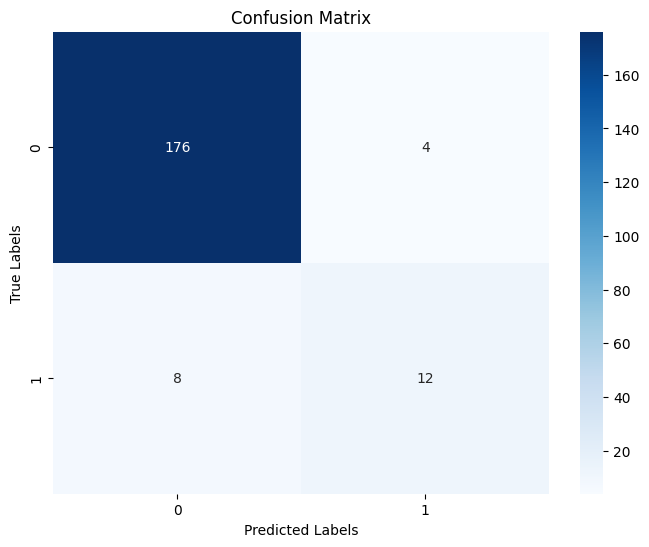

In [ ]:
plt.figure(figsize =(8,6))
cm = confusion_matrix(y_test, y_pred) #how often predicted labels match the true labels
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues') #format annotation
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()